In [17]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch.utils.data import DataLoader,TensorDataset
from plots.gifs import trajectory_gif
from plots.plots import get_feature_history, plt_train_error, plt_norm_state, plt_norm_control, plt_classifier, feature_plot, plt_dataset
from models.training import Trainer, robTrainer, epsTrainer
from models.neural_odes import NeuralODE, robNeuralODE
from models.resnets import ResNet
import pickle
import sys
import matplotlib.pyplot as plt
import imageio
import math

from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

#if training = False, models will be loaded from file


In [18]:
hidden_dim, data_dim = 2, 2
T, num_steps = 5.0, 10  #T is the end time, num_steps are the amount of discretization steps for the ODE solver
dt = T/num_steps
turnpike = False
bound = 0.
fp = False
cross_entropy = True
noise = 0.01
shuffle = False
non_linearity = 'relu' #'tanh'
architecture = 'bottleneck' #outside

eps = 0.01
v_steps = 5


training = True #train new network or load saved one
num_epochs = 100 #number of optimization epochs for gradient decent

if turnpike:
    weight_decay = 0 if bound>0. else dt*0.01
else: 
    weight_decay = dt*0.01          #0.01 for fp, 0.1 else

In [19]:
eps_node = NeuralODE(device, data_dim, hidden_dim, adjoint = False, augment_dim=0, non_linearity=non_linearity, 
                            architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)


optimizer_node = torch.optim.Adam(eps_node.parameters(), lr=1e-3, weight_decay=weight_decay) #weight decay parameter modifies norm
trainer_eps_node = epsTrainer(eps_node, optimizer_node, device, cross_entropy=cross_entropy, 
                        turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False, eps =  eps)


anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)

optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3, weight_decay=weight_decay) #weight decay parameter modifies norm
trainer_anode = Trainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, 
                        turnpike=turnpike, bound=bound, fixed_projector=fp, verbose = False)                    

In [20]:
X, y = make_circles(3000, noise=noise, factor=0.15, random_state=1)
# X, y = make_moons(3000, noise = noise, random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05)

X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_test = torch.Tensor(X_train) # transform to torch tensor for dataloader
y_test = torch.Tensor(y_train) #transform to torch tensor for dataloader

X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
y_train = y_train.type(torch.int64) #dtype of original picle.load data

X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
y_test = y_test.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X_train,y_train) # create your datset
test = TensorDataset(X_test, y_test)

dataloader = DataLoader(data_line, batch_size=64, shuffle=shuffle)
dataloader_viz = DataLoader(data_line, batch_size=128, shuffle=shuffle)

trainer_eps_node.train(dataloader, num_epochs)
trainer_anode.train(dataloader, num_epochs)

loss max tensor(7.0058, grad_fn=<SumBackward0>)
loss max tensor(8.0910, grad_fn=<SumBackward0>)
loss max tensor(8.1293, grad_fn=<SumBackward0>)
loss max tensor(8.6336, grad_fn=<SumBackward0>)
loss max tensor(8.6336, grad_fn=<SumBackward0>)
loss max tensor(8.6798, grad_fn=<SumBackward0>)
loss max tensor(8.6798, grad_fn=<SumBackward0>)
loss max tensor(8.7136, grad_fn=<SumBackward0>)
loss tensor(0.9798, grad_fn=<AddBackward0>)
loss max tensor(6.8513, grad_fn=<SumBackward0>)
loss max tensor(7.9082, grad_fn=<SumBackward0>)
loss max tensor(7.9756, grad_fn=<SumBackward0>)
loss max tensor(8.5156, grad_fn=<SumBackward0>)
loss max tensor(8.5158, grad_fn=<SumBackward0>)
loss max tensor(8.5330, grad_fn=<SumBackward0>)
loss max tensor(8.5335, grad_fn=<SumBackward0>)
loss max tensor(8.5648, grad_fn=<SumBackward0>)
loss tensor(1.0005, grad_fn=<AddBackward0>)
loss max tensor(6.8410, grad_fn=<SumBackward0>)
loss max tensor(7.8886, grad_fn=<SumBackward0>)
loss max tensor(7.9180, grad_fn=<SumBackward0>)


normal


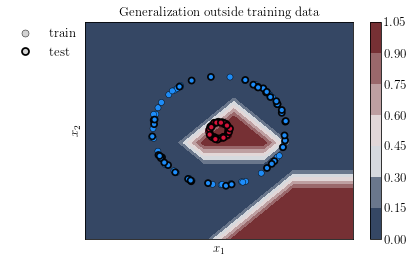

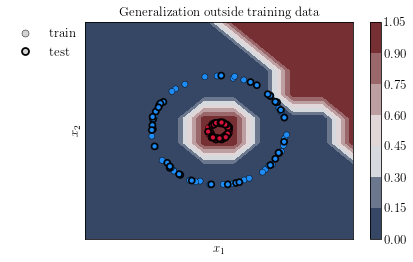

In [21]:

print('normal')
plt_classifier(anode, data_line, test, num_steps=10, save_fig = '1generalization.png') 
plt_classifier(eps_node, data_line, test, num_steps=10, save_fig = '1generalization_eps.png') 

In [6]:
filename_base = '1traj'

filename_s = filename_base + '_s'
filename_r = filename_base + '_r'
inputs, targets = next(iter(dataloader_viz))
trajectory_gif(eps_node, inputs, targets, timesteps=num_steps, filename = filename_r + '.gif')
trajectory_gif(anode, inputs, targets, timesteps=num_steps, filename = filename_s +'.gif')


In [7]:
x = torch.tensor([1.,2.])

anode(x)
out, traj = anode(x + torch.tensor([[0.5,1],[0.5,0.5]]))

# print(traj)
# out.square()

X, y = make_circles(5, noise=noise, factor=0.15, random_state=1)

X = torch.Tensor(X) # transform to torch tensor for dataloader
y = torch.Tensor(y) #transform to torch tensor for dataloader

X = X.type(torch.float32)  #type of orginial pickle.load data
y = y.type(torch.int64) #dtype of original picle.load data


data_line = TensorDataset(X,y)
data_loader = DataLoader(data_line, batch_size=3, shuffle=False)

for i, (x_batch, y_batch) in enumerate(data_loader):      
    y_pred, traj  = anode(x_batch)
    loss_max = torch.tensor(0.)
    #generate perturbed directions
    for k in range(v_steps):
        t = k*(2*torch.tensor(math.pi))/v_steps
        v = torch.tensor([torch.sin(t),torch.cos(t)])
        print('direction',v)
        
        y_eps, traj_eps = anode(x_batch + eps*v) #model for perturbed input
        loss_v = (traj_eps - traj).abs().sum(dim = 0) #for trapezoidal rule. endpoints not regarded atm
        loss_max = torch.maximum(loss_max,loss_v)
        # print('loss_v', loss_v)
        # print('loss max',loss_max)
        
    print('final loss max',loss_max.sum())
    break
        
    
    
    

print(sum([traj[k,:] for k in range(len(traj))]))
# print(sum(traj)) #sums the trajectory batch wise



# print(len(traj))

direction tensor([0., 1.])
direction tensor([0.9511, 0.3090])
direction tensor([ 0.5878, -0.8090])
direction tensor([-0.5878, -0.8090])
direction tensor([-0.9511,  0.3090])
final loss max tensor(3.0038, grad_fn=<SumBackward0>)
tensor([[ -7.6719,   5.4920],
        [ 33.8723, -24.7268],
        [ -5.4609,   3.7788]], grad_fn=<AddBackward0>)


In [8]:
# print(traj[:,0])
# print(traj[:,0].abs().sum(dim=0))
# traj.abs().sum(dim=0)

out_low = traj.abs().sum(dim=0)
out_high = traj.abs().sum(dim=0) + 1

print(out_low)
print(out_high)

print(torch.maximum(out_low,out_high))

tensor([[ 7.9308,  5.5969],
        [33.8723, 24.7268],
        [ 7.9326,  5.3968]], grad_fn=<SumBackward1>)
tensor([[ 8.9308,  6.5969],
        [34.8723, 25.7268],
        [ 8.9326,  6.3968]], grad_fn=<AddBackward0>)
tensor([[ 8.9308,  6.5969],
        [34.8723, 25.7268],
        [ 8.9326,  6.3968]], grad_fn=<MaximumBackward>)


In [9]:

# sum([traj[k,:] + traj[k+1,:] for k in range(len(traj[:,0])-1)])

# traj[:,0]

traj[0,:] + traj[0+1,:]

tensor([[-0.2434,  0.2278],
        [ 3.5063, -2.6712],
        [ 0.8380, -0.5455]], grad_fn=<AddBackward0>)

In [10]:
N=5
v= torch.zeros(N,2)
for k in range(N):
    t = k*(2*torch.tensor(math.pi))/N
    v[k] = torch.tensor([torch.sin(t),torch.cos(t)])
    print('direction {}'.format(k),v[k])
    
    
    print('perturbed output\n')
    print(out)
print('direction',v)


direction 0 tensor([0., 1.])
perturbed output

tensor([[-2.1079,  1.0230],
        [-1.4197,  0.6414]], grad_fn=<AddmmBackward>)
direction 1 tensor([0.9511, 0.3090])
perturbed output

tensor([[-2.1079,  1.0230],
        [-1.4197,  0.6414]], grad_fn=<AddmmBackward>)
direction 2 tensor([ 0.5878, -0.8090])
perturbed output

tensor([[-2.1079,  1.0230],
        [-1.4197,  0.6414]], grad_fn=<AddmmBackward>)
direction 3 tensor([-0.5878, -0.8090])
perturbed output

tensor([[-2.1079,  1.0230],
        [-1.4197,  0.6414]], grad_fn=<AddmmBackward>)
direction 4 tensor([-0.9511,  0.3090])
perturbed output

tensor([[-2.1079,  1.0230],
        [-1.4197,  0.6414]], grad_fn=<AddmmBackward>)
direction tensor([[ 0.0000,  1.0000],
        [ 0.9511,  0.3090],
        [ 0.5878, -0.8090],
        [-0.5878, -0.8090],
        [-0.9511,  0.3090]])
